<a href="https://colab.research.google.com/github/Luisinho-31/Kapital_Bank_Challenge/blob/main/Kapital_Bank_credit_LFCG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importacion de Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json


In [2]:

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, brier_score_loss
)
from sklearn.metrics import  precision_score, recall_score, f1_score, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carga del Dataset

In [4]:
ruta = '/content/drive/MyDrive/Kapital Bank/Creditos Otorgados KB.xlsx'


In [5]:
excel = pd.read_excel(ruta, sheet_name=None)
print(excel.keys())

dict_keys(['Créditos Otorgados', 'Ventas mensuales'])


In [6]:
credit = excel['Créditos Otorgados']

## Ingenieria de variables

In [7]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

In [8]:
missing_zero_values_table(credit)

Your selected dataframe has 55 columns and 7920 Rows.
There are 1 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
saldo_actual_act,136,45,0.6,181,2.3,float64


In [9]:
credit.head()

,ID,ind_malo,edad,sexo,medio_contacto,nivel_estudios,estado_civil,dependientes_economicos_id,tipo_vivienda,en_zona_cobertura,...,BANCO_PF,BANCO_RV,AUTO,TIENDA_COMERCIAL,FINANCIERA,MICROFINANCIERA,COMUNICACIONES,OTROS,con_6m,con_2m
0,4233,0,28,Hombre,Revista,Licenciatura,Soltero,0,Vivo con familiares,1,...,0.166667,0.500000,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,0,0
1,4391,0,38,Hombre,Facebook,Licenciatura,Union Libre,1,Rentada,1,...,0.000000,0.000000,0.0,0.011236,0.629213,0.269663,0.022472,0.067416,11,7
2,5159,0,37,Hombre,Facebook,Licenciatura,Casado (bienes separados),3,Propia,1,...,0.000000,0.538462,0.0,0.000000,0.000000,0.000000,0.230769,0.230769,1,1
3,5525,0,33,Mujer,Por Internet,Licenciatura,Casado (bienes separados),0,Propia,3,...,0.052632,0.421053,0.0,0.157895,0.000000,0.000000,0.315789,0.000000,3,2
4,6219,0,27,Mujer,Facebook,Licenciatura,Soltero,1,Vivo con familiares,1,...,0.000000,0.888889,0.0,0.111111,0.000000,0.000000,0.000000,0.000000,2,2


In [11]:
credit.columns

Index(['ID', 'ind_malo', 'edad', 'sexo', 'medio_contacto', 'nivel_estudios',
       'estado_civil', 'dependientes_economicos_id', 'tipo_vivienda',
       'en_zona_cobertura', 'bc_score', 'icc', 'destino', 'tipo_mail',
       'tipo_mail_rango', 'correo_otro', 'gma', 'hot', 'out', 'yah',
       'monto_prom', 'monto_12m', 'monto_act', 'porc_deuda_12m', 'porc_fijos',
       'hist_suf', 'hist_suf_pf', 'hist_suf_rv', 'pagos_suf_PF',
       'pagos_suf_RV', 'pagos_suf', 'creditos_general', 'creditos_general_ab',
       'creditos_recientes', 'creditos_3_anios', 'Saldo_Vencido_act',
       'saldo_actual_act', 'Saldo_Actual_PF', 'Saldo_Actual_RV',
       'saldo_vigente_rev', 'porc_deuda_rev', 'porc_mop_1', 'ind_mop_4_9',
       'mop_max_act', 'BANCO_HIP', 'BANCO_PF', 'BANCO_RV', 'AUTO',
       'TIENDA_COMERCIAL', 'FINANCIERA', 'MICROFINANCIERA', 'COMUNICACIONES',
       'OTROS', 'con_6m', 'con_2m'],
      dtype='object')

In [10]:

#Variable objetivo

target ='ind_malo'

y = credit[target]
X = credit.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('Train: ', X_train.shape)
print('Test: ', X_test.shape)

Train:  (5544, 54)
Test:  (2376, 54)


In [11]:
# Columnas categoricas y numericas

num_cols = X_train.select_dtypes(include=[('int64','float64')]).columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

print('Numericas: ', num_cols)
print('Categoricas: ', cat_cols)

Numericas:  ['ID', 'edad', 'en_zona_cobertura', 'bc_score', 'icc', 'destino', 'correo_otro', 'gma', 'hot', 'out', 'yah', 'monto_12m', 'monto_act', 'hist_suf', 'hist_suf_pf', 'hist_suf_rv', 'pagos_suf_PF', 'pagos_suf_RV', 'pagos_suf', 'creditos_general', 'creditos_general_ab', 'creditos_3_anios', 'Saldo_Vencido_act', 'Saldo_Actual_PF', 'Saldo_Actual_RV', 'saldo_vigente_rev', 'ind_mop_4_9', 'mop_max_act', 'con_6m', 'con_2m']
Categoricas:  ['sexo', 'medio_contacto', 'nivel_estudios', 'estado_civil', 'dependientes_economicos_id', 'tipo_vivienda', 'tipo_mail', 'tipo_mail_rango']


In [12]:
# vairables numericas

numeric_features = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

try:
  ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except:
  ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
# Variables Categoricas to binarias
categorical_features = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe)
])

for col in cat_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)


# Preproceso se trasnforma las coumnas categoricas y numericas
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_features, num_cols),
    ('cat', categorical_features, cat_cols)
], remainder='drop')

In [15]:
# credit.info()

In [13]:
credit['ind_malo'].value_counts(normalize=True) * 100

,proportion
ind_malo,
0,77.588384
1,22.411616


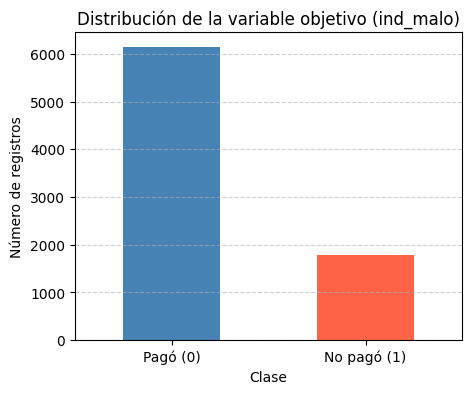

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
credit['ind_malo'].value_counts().plot(kind='bar', color=['steelblue', 'tomato'])
plt.title('Distribución de la variable objetivo (ind_malo)')
plt.xlabel('Clase')
plt.ylabel('Número de registros')
plt.xticks([0,1], ['Pagó (0)', 'No pagó (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## Modelado

In [16]:
!pip -q install xgboost imbalanced-learn

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

In [18]:
models = {
    'Logistic Regression': LogisticRegression( max_iter=1000, class_weight='balanced',n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=250, class_weight='balanced',random_state=42,n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=250, learning_rate =0.05,random_state=42),
    'XGBoost': XGBClassifier(n_estimators=250, learning_rate =0.05,max_depth = 4, subsample =0.8,colsample_bytree=0.8), # se usa el 80% de columnas de cada arbol
                            #  eval_metric = 'logloss',tree_method ='hist',random_state=42,n_jobs=-1),
    'MLP' : MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state= 42)  # red neuronal
}



In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores ={}
for nombre, modelo in models.items():
  pipe = Pipeline([('prep', preprocessor), ('clf', modelo)])
  auc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc',n_jobs =-1).mean()
  cv_scores[nombre] = auc

ranking = sorted(cv_scores.items(), key= lambda x:x[1],reverse= True)
ranking

for nombre, auc in ranking:
  print(f'{nombre}: {auc:.6f}')

XGBoost: 0.716648
Gradient Boosting: 0.715815
Random Forest: 0.708588
Logistic Regression: 0.700533
MLP: 0.619643


In [20]:
best_name = max(cv_scores, key=cv_scores.get)
best_model = models[best_name]

pipe_best = Pipeline([('prep', preprocessor), ('clf', best_model)])
pipe_best.fit(X_train, y_train)

proba_test = pipe_best.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, proba_test)

#KS

fpr, tpr, thr = roc_curve(y_test, proba_test)
ks = np.max(tpr - fpr)

# PR - AUC
pr_auc = average_precision_score(y_test, proba_test)

# brier
brier = brier_score_loss(y_test, proba_test)



In [36]:
print('Modelo : ',best_name)
print('AUC en test: ', auc_test)
print('KS: ', ks)
print('PR-AUC: ', pr_auc)
print('Brier: ', brier)

Modelo :  XGBoost
AUC en test:  0.7038365030369412
KS:  0.31713033953997805
PR-AUC:  0.40554140178473685
Brier:  0.16254379711410924


## Curva roc

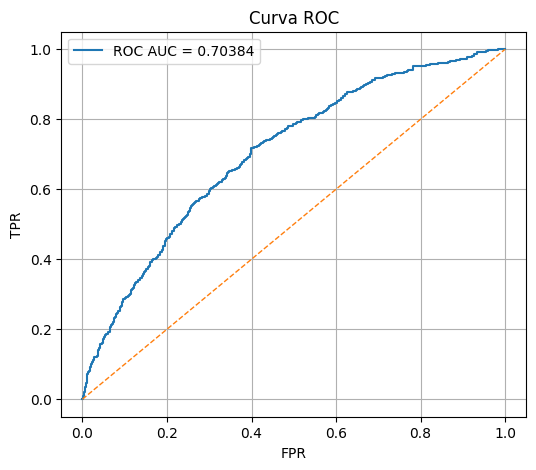

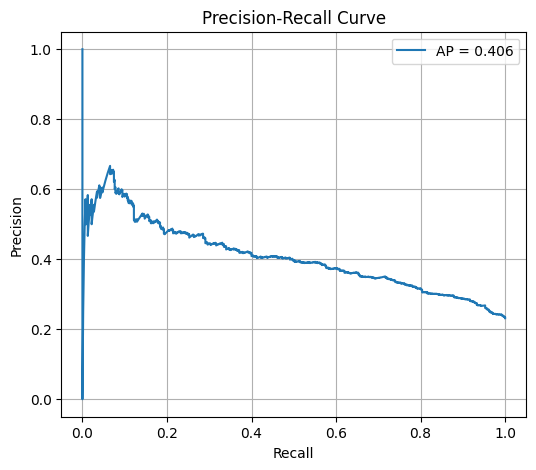

In [35]:
# ROC
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC = {auc_test:.5f}')
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f'AP = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
fpr, tpr, thr =roc_curve(y_test, proba_test)
ks = np.max(tpr - fpr)
ks
best_idx =ks.argmax()
best_thr = thr[best_idx]
best_thr

np.float32(inf)

In [24]:
cut_p80 = np.quantile(proba_test, 0.8)
print(cut_p80)

0.34012517


## Matriz Confusión

In [25]:
cut = cut_p80
y_pred = (proba_test >= cut).astype(int)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [26]:
print('CM ',cm)
print('Precision:',precision,'Recall: ', recall,'F1', f1 )

print('y_pred',y_pred)


CM  [[1552  274]
 [ 348  202]]
Precision: 0.42436974789915966 Recall:  0.36727272727272725 F1 0.3937621832358674
y_pred [0 1 1 ... 0 0 0]


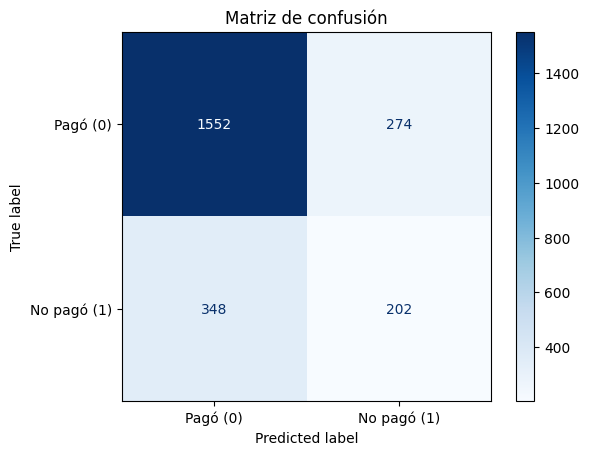

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pagó (0)', 'No pagó (1)'])
disp.plot(cmap='Blues')
plt.title('Matriz de confusión')
plt.show()

In [28]:
tmp = pd.DataFrame({'y': y_test.values, 'p': proba_test}).sort_values('p', ascending=False)
# manejo estable de empates
tmp['decile'] = pd.qcut(tmp['p'].rank(method='first'), 10, labels=False)

gain = tmp.groupby('decile').agg(
    volumen=('y','size'), malos=('y','sum'), p_mean=('p','mean')
).sort_index(ascending=False)

gain['malos_acum']       = gain['malos'].cumsum()
gain['volumen_acum']     = gain['volumen'].cumsum()
gain['capture_rate_acum']= gain['malos_acum'] / gain['malos'].sum()
gain

,volumen,malos,p_mean,malos_acum,volumen_acum,capture_rate_acum
decile,,,,,,
9,238,115,0.559388,115,238,0.209091
8,237,87,0.385948,202,475,0.367273
7,238,79,0.302015,281,713,0.510909
6,237,64,0.241865,345,950,0.627273
5,238,59,0.194594,404,1188,0.734545
4,237,38,0.157064,442,1425,0.803636
3,238,42,0.128144,484,1663,0.880000
2,237,29,0.101044,513,1900,0.932727
1,238,18,0.072379,531,2138,0.965455


,0
pagos_suf_RV,0.031103
con_6m,0.026171
nivel_estudios_Secundaria,0.022126
nivel_estudios_Licenciatura,0.021796
dependientes_economicos_id_0,0.021170
medio_contacto_Kueski,0.020128
saldo_vigente_rev,0.019541
con_2m,0.018952
medio_contacto_Facebook,0.018790
icc,0.018397


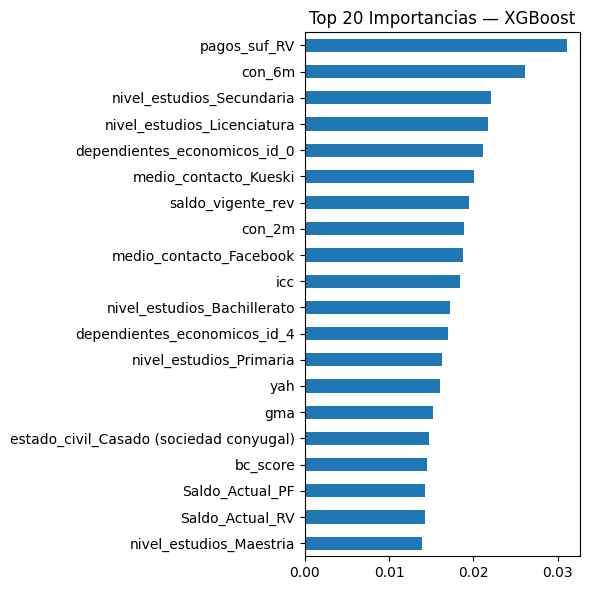

In [29]:
# nombres de features transformados
#4
prep = pipe_best.named_steps['prep']
num_names = list(num_cols)

try:
    ohe = prep.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(cat_cols).tolist()
except Exception:
    cat_names = []

feature_names = num_names + cat_names

xgb = pipe_best.named_steps['clf']
import pandas as pd, matplotlib.pyplot as plt

imp = pd.Series(xgb.feature_importances_, index=feature_names)\
        .sort_values(ascending=False)

top20 = imp.head(20)
display(top20)

plt.figure(figsize=(6,6))
top20.sort_values().plot(kind='barh')
plt.title('Top 20 Importancias — XGBoost')
plt.tight_layout(); plt.show()


In [30]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score
#5
cal_xgb = CalibratedClassifierCV(pipe_best, method='isotonic', cv=3)
cal_xgb.fit(X_train, y_train)
proba_test_cal = cal_xgb.predict_proba(X_test)[:,1]

print("AUC(cal):", roc_auc_score(y_test, proba_test_cal))
print("Brier(cal):", brier_score_loss(y_test, proba_test_cal))


AUC(cal): 0.7098790202130837
Brier(cal): 0.15985412501036966


In [31]:
salida = pd.DataFrame({
    'y_true': y_test.values,
    'proba_xgb': proba_test,
    'flag_top20': (proba_test >= np.quantile(proba_test, 0.80)).astype(int)
})
salida_path = '/content/Resultados_XGB_Test.csv'
salida.to_csv(salida_path, index=False)
salida_path


'/content/Resultados_XGB_Test.csv'

In [32]:
pos = y_train.sum()
neg = len(y_train) - pos
spw = neg / max(pos,1)
print("scale_pos_weight ~", round(spw,2))


scale_pos_weight ~ 3.53
